In [1]:
from keras import optimizers, regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from random import shuffle
from scipy import interp
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import gmean
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import QuantileTransformer
import contextlib
import glob
import gzip
import h5py
import keras
import numpy as np
import os
import pandas as pd
import pylab as plt
import random
import scipy
import sklearn
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.svm import SVC



random_state = np.random.RandomState(0)


Using TensorFlow backend.


In [2]:
X_f_ext = '/home/drewe/notebooks/genotox/mutagenicity-fingerprints.csv'

X = pd.read_csv(X_f_ext,sep=',')
X['Mutagenicity_bin'] = np.int32(X['Mutagenicity'] == 'mutagenic')
del X['Mutagenicity']

X_f_ext = '/home/drewe/notebooks/genotox/mutagenicity-mod-2.csv'

X_ext = pd.read_csv(X_f_ext,sep=';')


X = pd.merge(X[['Canonical SMILES','Mutagenicity_bin']], X_ext, left_on='Canonical SMILES', right_on='Name')
y = X['Mutagenicity_bin'].values
del X['Mutagenicity_bin']
del X['Name']



In [3]:


'''
X_f_ext = '/home/drewe/notebooks/genotox/mutagenicity-mod-2.csv'
X = pd.read_csv(X_f_ext,sep=',')

y = np.int32(X['Mutagenicity'] == 'mutagenic')
del X['Mutagenicity']

'''

x_pad = pd.read_csv('/home/drewe/notebooks/genotox/PA_Padel_2D_m2.csv', sep=';', decimal=',')
selected_cols = list(set(x_pad.columns.tolist()).intersection(set(X.columns.tolist())))
X = np.float64(X[selected_cols].values)
x_pad = np.float64(x_pad[selected_cols].values)
print(X.shape)
print(y.shape)
print(x_pad.shape)

names = pd.read_csv('/home/drewe/notebooks/genotox/PA_Padel_2D_m2.csv', sep=';')['Name'].values
#X_norm = QuantileTransformer(output_distribution='uniform').fit_transform(X.values.T).T


#X = pd.merge(X_ext,X[['Canonical SMILES','Mutagenicity_bin']],  right_on='Canonical SMILES', left_on='Name')
#X = np.float64(X.values[:,1:])

(8083, 1173)
(8083,)
(602, 1173)


/fast_data/drewe/software/envs/tf_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (517,531,534,542,545,547,573,576,599,601,604,607,620,627,629,636,650,653,661,664,666,692,695,718,720,723,726,739,746,748,755,769,772,780,783,785,805,811,814,819,837,845,901,1005) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:


trnsf = sklearn.preprocessing.QuantileTransformer( output_distribution='uniform')
trnsf.fit(X)

X = trnsf.transform(X)
x_pad = trnsf.transform(x_pad)


In [9]:
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0

keras.backend.clear_session()
prbs=[]
for mod in range(5):
    print('>>')
    curr_try = 0
    while curr_try <10:
        print('.')

        model = Sequential()
        model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        opt = keras.optimizers.Adam(epsilon=None, amsgrad=True)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Fit the model
        history = model.fit(X, y, epochs=50, batch_size=64, verbose=0)
        if history.history['acc'][-1] > 0.53:
            break
        else:
            curr_try += 1

    # Fit the model
    probas_ = model.predict(x_pad)
    prbs.append(probas_)
# Average the predictions
probas_ = np.mean(np.hstack(prbs), axis=1)
results = probas_




>>
.
>>
.
>>
.
>>
.
>>
.


In [10]:
df_results = pd.DataFrame(data={"name": names, 'pred': results})
df_results.to_csv('/home/drewe/notebooks/genotox/pred.nn.v5-ext-Padel-2D.csv', index=None)

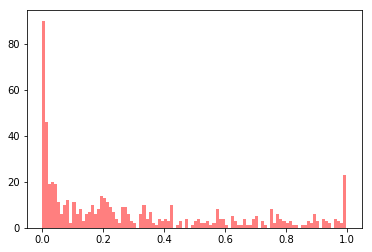

In [11]:
plt.hist(results,100, color='red', alpha=0.5)
plt.show()

In [12]:
#Logistic regression (SGD)
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
keras.backend.clear_session()
prbs=[]
for mod in range(5):
    print('>>')
    curr_try = 0
    while curr_try <10:
        print('.')

        model = Sequential()
        model.add(Dense(1, activation='sigmoid'))
        # Compile model
        opt = keras.optimizers.Adam(epsilon=None, amsgrad=True)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Fit the model
        history = model.fit(X, y, epochs=50, batch_size=64, verbose=0)
        if history.history['acc'][-1] > 0.53:
            break
        else:
            curr_try += 1

    # Fit the model
    model.fit(X, y, epochs=50, batch_size=64, verbose=1)

    # evaluate the model
    probas_ = model.predict(x_pad)
    prbs.append(probas_)
# Average the predictions
probas_ = np.mean(np.hstack(prbs), axis=1)
results = probas_

>>
.
Epoch 1/50
8083/8083 [==============================] - 0s 59us/step - loss: 0.4486 - acc: 0.7936
Epoch 2/50
8083/8083 [==============================] - 0s 40us/step - loss: 0.4490 - acc: 0.7949
Epoch 3/50
8083/8083 [==============================] - 0s 40us/step - loss: 0.4472 - acc: 0.7967
Epoch 4/50
8083/8083 [==============================] - 0s 37us/step - loss: 0.4461 - acc: 0.7982
Epoch 5/50
8083/8083 [==============================] - 0s 39us/step - loss: 0.4455 - acc: 0.7977
Epoch 6/50
8083/8083 [==============================] - 0s 40us/step - loss: 0.4471 - acc: 0.8002
Epoch 7/50
8083/8083 [==============================] - 0s 38us/step - loss: 0.4450 - acc: 0.7966
Epoch 8/50
8083/8083 [==============================] - 0s 38us/step - loss: 0.4445 - acc: 0.7991
Epoch 9/50
8083/8083 [==============================] - 0s 40us/step - loss: 0.4467 - acc: 0.7949
Epoch 10/50
8083/8083 [==============================] - 0s 42us/step - loss: 0.4454 - acc: 0.7977
Epoch 11/50
80

Epoch 16/50
8083/8083 [==============================] - 0s 39us/step - loss: 0.4430 - acc: 0.7972
Epoch 17/50
8083/8083 [==============================] - 0s 37us/step - loss: 0.4428 - acc: 0.7975
Epoch 18/50
8083/8083 [==============================] - 0s 38us/step - loss: 0.4433 - acc: 0.7950
Epoch 19/50
8083/8083 [==============================] - 0s 40us/step - loss: 0.4430 - acc: 0.7980
Epoch 20/50
8083/8083 [==============================] - 0s 38us/step - loss: 0.4410 - acc: 0.8003
Epoch 21/50
8083/8083 [==============================] - 0s 38us/step - loss: 0.4421 - acc: 0.7971
Epoch 22/50
8083/8083 [==============================] - 0s 39us/step - loss: 0.4426 - acc: 0.7993
Epoch 23/50
8083/8083 [==============================] - 0s 38us/step - loss: 0.4393 - acc: 0.8013
Epoch 24/50
8083/8083 [==============================] - 0s 38us/step - loss: 0.4385 - acc: 0.8001
Epoch 25/50
8083/8083 [==============================] - 0s 37us/step - loss: 0.4379 - acc: 0.8019
Epoch 26/5

In [13]:
df_results = pd.DataFrame(data={"name": names, 'pred': results})
df_results.to_csv('/home/drewe/notebooks/genotox/pred.lr.v5-ext-Padel-2D.csv', index=None)

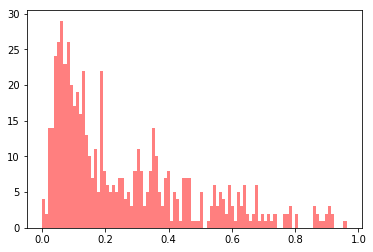

In [14]:
plt.hist(results,100, color='red', alpha=0.5)
plt.show()

In [15]:
#Logistic regression (scikit)
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
keras.backend.clear_session()
prbs=[]
model = LogisticRegression(random_state=0)
model.fit(X, y)
probas_ = model.predict_proba(x_pad)[:, 1]
results = probas_


/fast_data/drewe/software/envs/tf_gpu/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
df_results = pd.DataFrame(data={"name": names, 'pred': results})
df_results.to_csv('/home/drewe/notebooks/genotox/pred.lr2.v5-ext-Padel-2D.csv', index=None)

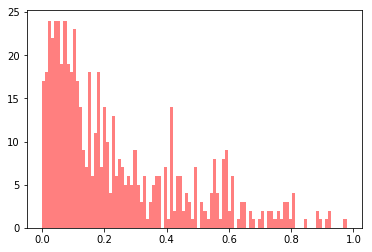

In [17]:
plt.hist(results,100, color='red', alpha=0.5)
plt.show()

In [18]:
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
keras.backend.clear_session()
prbs=[]
model = RandomForestClassifier(n_estimators=1000, random_state=0, max_leaf_nodes=200)
# Fit the model
model.fit(X, y)


probas_ = model.predict_proba(x_pad)[:, 1]
results = probas_

In [19]:
df_results = pd.DataFrame(data={"name": names, 'pred': results})
df_results.to_csv('/home/drewe/notebooks/genotox/pred.rf.v5-ext-Padel-2D.csv', index=None)

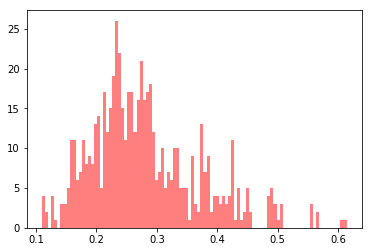

In [20]:
plt.hist(results,100, color='red', alpha=0.5)
plt.show()

In [5]:
cv = StratifiedKFold(n_splits=10)
results = np.zeros_like(y, dtype=float)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
keras.backend.clear_session()
prbs=[]
model = SVC(kernel='rbf', gamma='scale', probability=True)
# Fit the model
model.fit(X, y)


probas_ = model.predict_proba(x_pad)[:, 1]
results = probas_

In [6]:
df_results = pd.DataFrame(data={"name": names, 'pred': results})
df_results.to_csv('/home/drewe/notebooks/genotox/pred.svm.v5-ext-Padel-2D.csv', index=None)

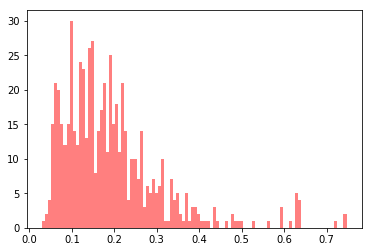

In [7]:
plt.hist(results,100, color='red', alpha=0.5)
plt.show()